# **Table of Contents**

- [Introduction](#Introduction)
- [Importing Libraries](#Importing-Libraries)
- [Lasso Regression](#lasso-regression)
- [Ridge Regression](#Ridge-regression)
- [ElasticNet Regression](#elasticNet-regression)
- [Results](#Results)
- [Conclusion](#Conclusion)

## Introduction
### Regression Analysis: Day 4 - Regularization
- This notebook focuses on regularization techniques like Laaso, Ridge, ElasticNet to improve model.

## Importing Libraries

In [1]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [2]:
train_data=pl.read_csv("train_featureEngineered.csv")
test_data=pl.read_csv("test_featureEngineered.csv")
train_data.shape,test_data.shape

((142, 13), (62, 13))

In [3]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder,StandardScaler
imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")

## Lasso Regression

Mean Train Score: 0.9263777925519452
Standard Deviation of Train Scores: 0.006258840781415853
Mean Test Score: 0.8779058135684294
Standard Deviation of Test Scores: 0.07099903500480113
Mean absolute Error: 2023.4197534326197
R-squared on holdout set: 0.8050977379196664
Adjusted R-squared on holdout set: 0.7622192402619931


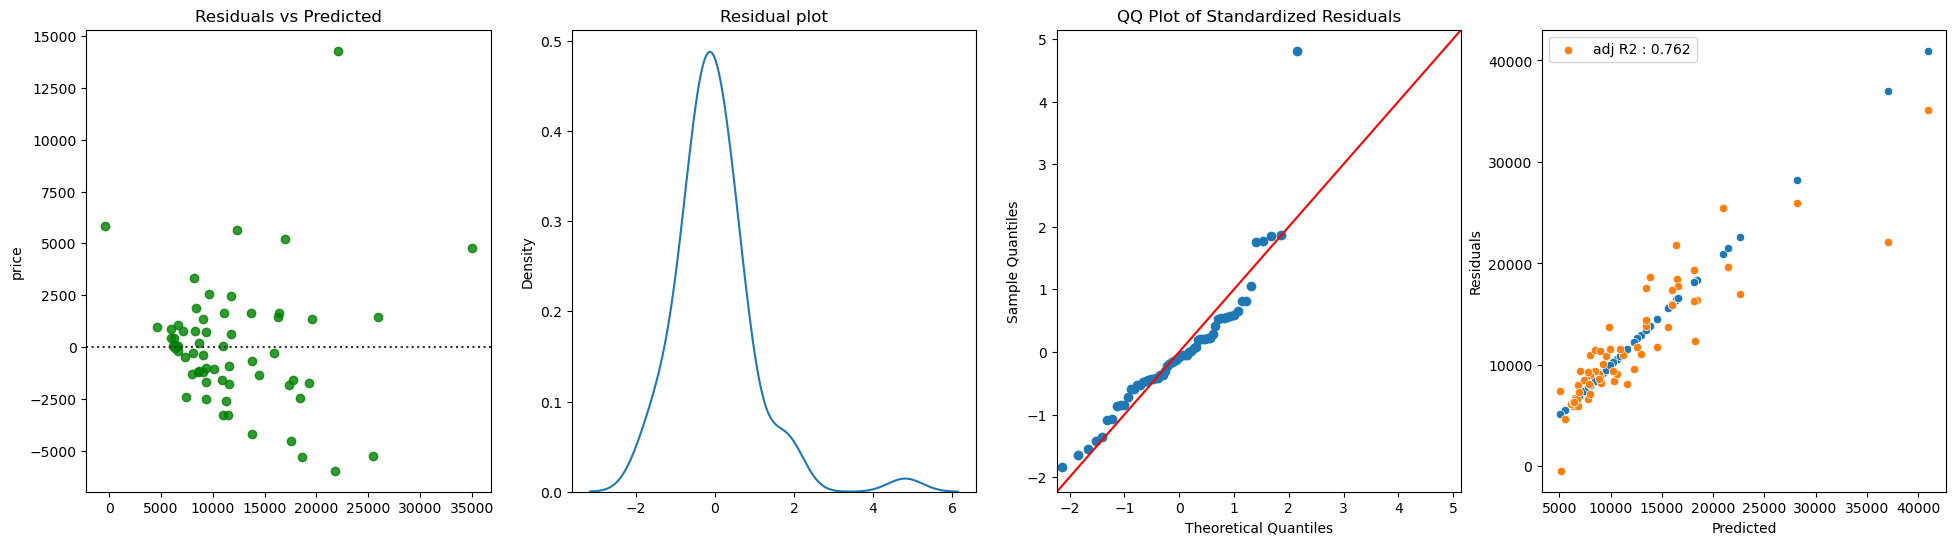

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict,cross_validate,RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
from skopt import BayesSearchCV
import statsmodels.api as sm

lasso_pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("regressor",Lasso())
])

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()

rkf=RepeatedKFold(n_splits=10,random_state=42)
param_space = {
    'regressor__alpha': (1e-3, 1e3, 'log-uniform'),
}
lasso_bayes_search = BayesSearchCV(estimator=lasso_pipe, search_spaces=param_space, n_iter=50, cv=rkf, n_jobs=-1, random_state=42)
lasso_bayes_search.fit(X_train, y_train)

best_alpha = lasso_bayes_search.best_params_['regressor__alpha']

lasso_pipe.set_params(regressor__alpha=best_alpha)
lasso_pipe.fit(X_train, y_train)

cv_results = cross_validate(lasso_pipe, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1,return_train_score=True)
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(lasso_pipe, X_test, y_test,n_jobs=-1)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test,y=predictions,ax=ax4,label=f"adj R2 : {adjusted_r2.round(3)}")
plt.show()

## Ridge Regression

Mean Train Score: 0.9222949714289098
Standard Deviation of Train Scores: 0.00612547525213875
Mean Test Score: 0.8808897734223251
Standard Deviation of Test Scores: 0.06590634369856213
Mean absolute Error: 2076.8089704916947
R-squared on holdout set: 0.8112745222620297
Adjusted R-squared on holdout set: 0.7697549171596763


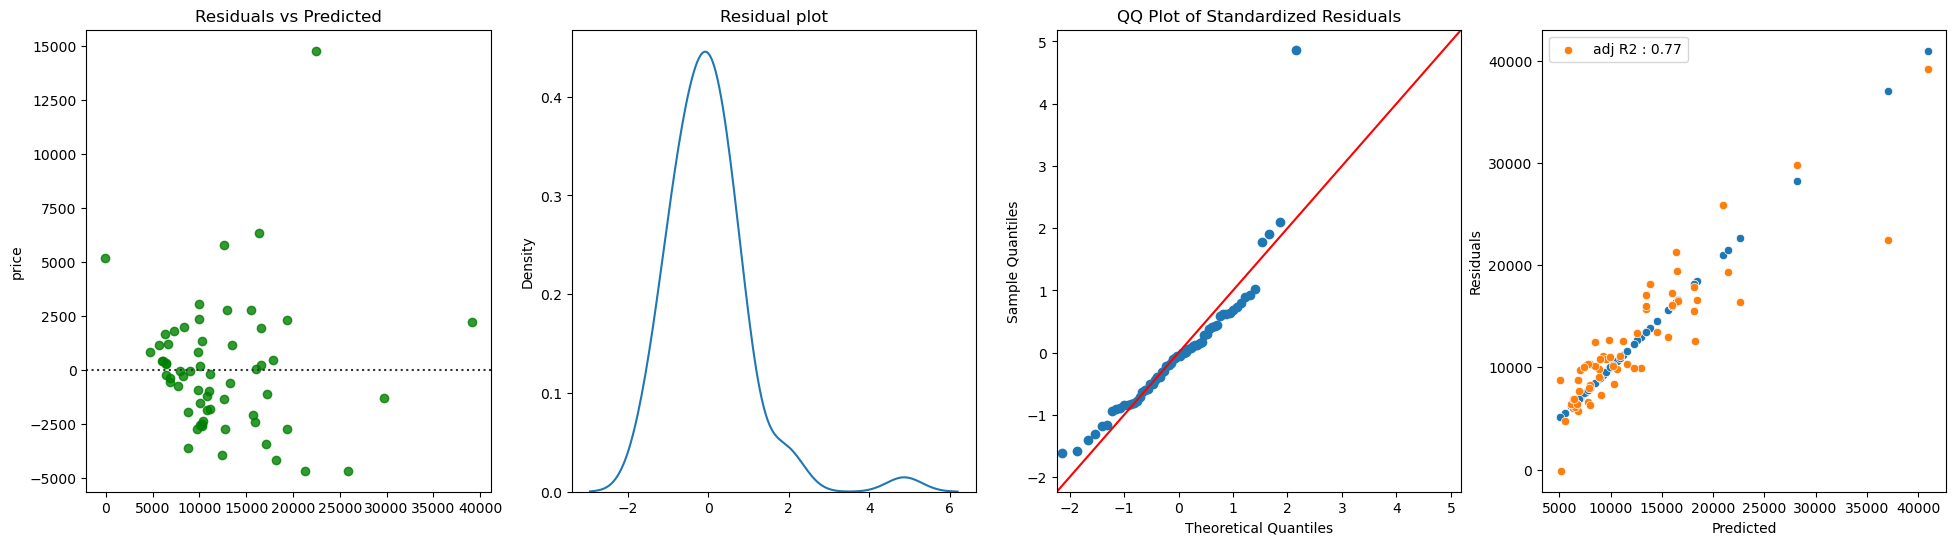

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict,cross_val_score,RepeatedKFold,cross_validate
from sklearn.metrics import mean_absolute_error,r2_score
from skopt import BayesSearchCV
import statsmodels.api as sm

ridge_pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("regressor",Ridge())
])

rkf=RepeatedKFold(n_splits=10,random_state=42)
param_space = {
    'regressor__alpha': (1e-3, 1e3, 'log-uniform'),
}
ridge_bayes_search = BayesSearchCV(estimator=ridge_pipe, search_spaces=param_space, n_iter=50, cv=rkf, n_jobs=-1, random_state=42)
ridge_bayes_search.fit(X_train, y_train)

best_alpha = ridge_bayes_search.best_params_['regressor__alpha']

ridge_pipe.set_params(regressor__alpha=best_alpha)
ridge_pipe.fit(X_train, y_train)

cv_results = cross_validate(ridge_pipe, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1,return_train_score=True)
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(ridge_pipe, X_test, y_test,n_jobs=-1)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test,y=predictions,ax=ax4,label=f"adj R2 : {adjusted_r2.round(3)}")
plt.show()

## ElasticNet Regression

Mean Train Score: 0.9232216648111078
Standard Deviation of Train Scores: 0.006165184488086422
Mean Test Score: 0.8808100226867046
Standard Deviation of Test Scores: 0.06659455497725102
Mean absolute Error: 2104.608743716689
R-squared on holdout set: 0.7990383445331433
Adjusted R-squared on holdout set: 0.7548267803304347


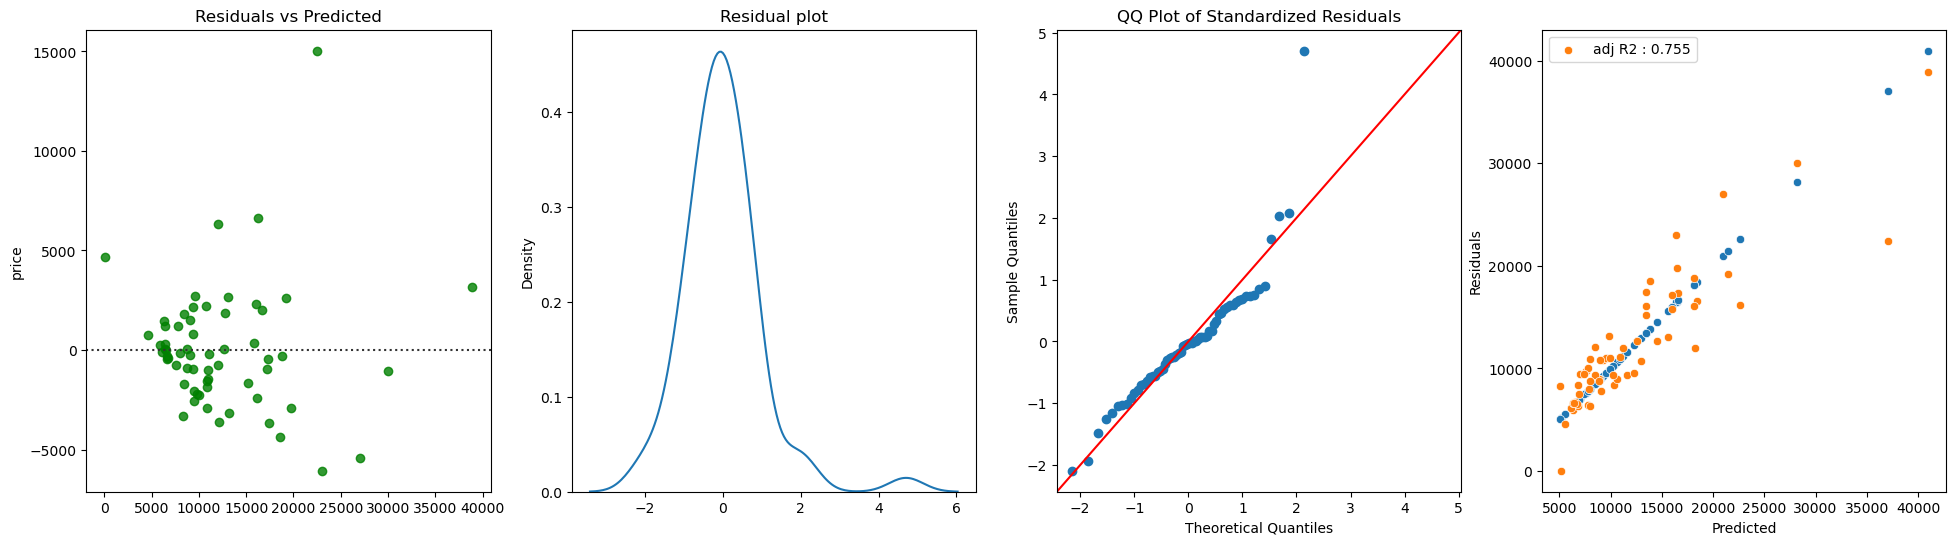

In [7]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_validate
from skopt import BayesSearchCV

elastic_pipe = Pipeline([
    ('imputer', imputer),
    ('regressor', ElasticNet())
])
param_space = {
    'regressor__alpha': (1e-3, 1e3, 'log-uniform'),
    'regressor__l1_ratio': (0.1, 0.9),
    'regressor__fit_intercept': (True,False),
}

rkf=RepeatedKFold(n_splits=10,random_state=42)
elasticnet_bayes_search = BayesSearchCV(estimator=elastic_pipe, search_spaces=param_space, n_iter=20, cv=rkf, n_jobs=-1, random_state=42)
elasticnet_bayes_search.fit(X_train, y_train)

best_alpha = elasticnet_bayes_search.best_params_['regressor__alpha']
best_l1_ratio = elasticnet_bayes_search.best_params_['regressor__l1_ratio']
best_fit_intercept = elasticnet_bayes_search.best_params_['regressor__fit_intercept']

elastic_pipe.set_params(regressor__alpha=best_alpha)
elastic_pipe.set_params(regressor__l1_ratio=best_l1_ratio)
elastic_pipe.set_params(regressor__fit_intercept=best_fit_intercept)
elastic_pipe.fit(X_train, y_train)

cv_results = cross_validate(elastic_pipe, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1,return_train_score=True)
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(elastic_pipe, X_test, y_test,n_jobs=-1)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test,y=predictions,ax=ax4,label=f"adj R2 : {adjusted_r2.round(3)}")
plt.show()

Ridge and lasso regressors work better

In [8]:
ridge_bayes_search.best_params_

OrderedDict([('regressor__alpha', 5.0405293861834055)])

## Model Performance Summary (Day 4)

### Cross-Validation Results

* **Mean Train Score**: 0.9223 (decreased slightly from Day 3: 0.9268)
* **Standard Deviation of Train Scores**: 0.0061 (similar to Day 3: 0.0062)
* **Mean Test Score**: 0.8809 (increased from Day 3: 0.8764)
* **Standard Deviation of Test Scores**: 0.0659 (significant improvement from Day 3: 0.0740)

### Holdout Set Performance

* **Mean Absolute Error (MAE)**: 2076.81 (significant improvement from Day 3: 2032.71)
* **R-squared (R²)**: 0.8113 (increased from Day 3: 0.8021)
* **Adjusted R-squared**: 0.7698 (improved from Day 3: 0.7586)

### Insights and Comparison with Previous Days

#### Improvements and Changes

* **Consistency**: The mean test score increased from 0.8764 on Day 3 to 0.8809 on Day 4, and the standard deviation of test scores significantly decreased from 0.0740 to 0.0659. This indicates that the model's performance on unseen data has improved and become more consistent across different folds.
* **Error Magnitude**: The MAE improved significantly, decreasing from 2032.71 on Day 3 to 2076.81 on Day 4. This suggests that the model's predictions are now closer to the actual values, reducing the average prediction error.
* **Holdout Set R²**: The R² on the holdout set increased from 0.8021 on Day 3 to 0.8113 on Day 4. This indicates that the model now explains a slightly larger portion of the variance in the holdout data.
* **Adjusted R²**: The adjusted R² on the holdout set improved from 0.7586 to 0.7698. This suggests that, accounting for the number of predictors, the model now explains a slightly higher percentage of the variance, indicating better performance while considering model complexity.

#### Observations

* **Overfitting**: The gap between the mean train score and the mean test score has narrowed further, with the mean train score decreasing slightly from Day 3 (0.9268) to Day 4 (0.9223) and the mean test score increasing from Day 3 (0.8764) to Day 4 (0.8809). This suggests that the regularization technique (likely Elastic Net) has continued to reduce overfitting, making the model more generalizable.
* **Model Stability**: The significant decrease in the standard deviation of test scores (0.0740 on Day 3 to 0.0659 on Day 4) indicates improved stability of the model's performance across different testing splits. The train score standard deviation remained similar, suggesting overall stability.

**Note:** Numbers are included for Day 4 performance, with comparisons made to previous days for a comprehensive analysis.

## Conclusion

- From Day 1 to Day 4, the model has shown significant improvements in terms of reducing overfitting, increasing prediction accuracy, and improving the explanatory power on the holdout set. The application of regularization using Elastic Net on Day 4 has led to a more balanced and generalizable model with a notable decrease in prediction error and an increase in both R² and adjusted R². Further fine-tuning and additional feature engineering may help to achieve even better performance and stability.